In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils

import pandas as pd
import numpy as np
import os
import pickle
from IPython.display import display, HTML
import finbox

In [2]:
country = 'JPN'
prediction_location = os.path.join(os.getcwd(), 'cache')

with open(os.path.join(prediction_location, '%s_preds_t120_p12.pickle' % country), 'rb') as f:
    preds = pickle.load(f)

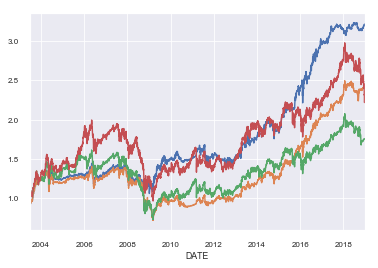

In [3]:
(preds['returns_0.0'] + 1).cumprod().plot()
(preds['returns_0.3'] + 1).cumprod().plot()
(preds['returns_0.5'] + 1).cumprod().plot()
(preds['returns_0.7'] + 1).cumprod().plot()

In [4]:
weights = utils.reverse_labels_to_weights(country, preds['preds'], 
                                          preds['probla'],
                                          preds['labels'],
                                          0.)
assets = utils.construct_virtual_assets(country)

## Performance Without Transactions

,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,21.57,2011-08-01,2012-07-25,2014-01-09,639
1,19.41,2007-11-22,2008-01-22,2009-03-26,351
2,19.40,2006-05-08,2006-06-13,2007-07-12,309
3,11.50,2014-07-29,2014-10-17,2015-02-26,153
4,11.28,2016-02-01,2016-02-12,2016-03-03,24


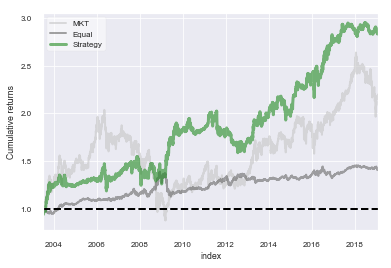

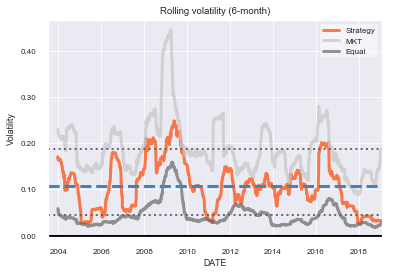

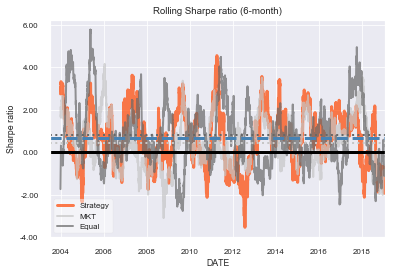

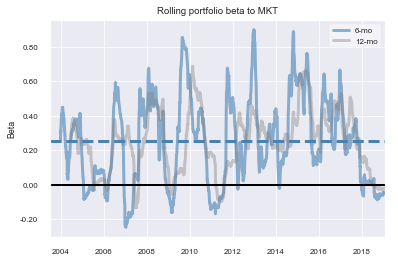

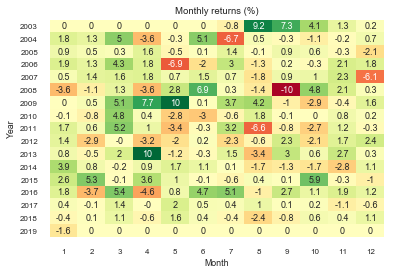

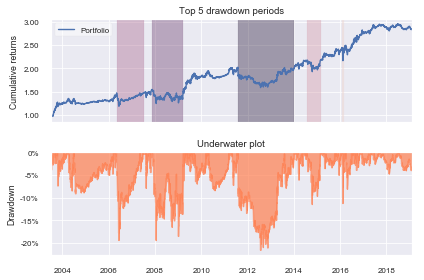

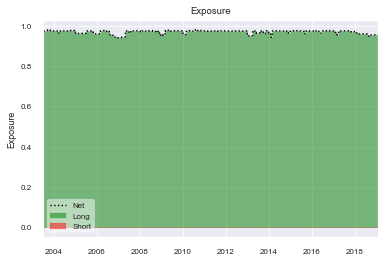

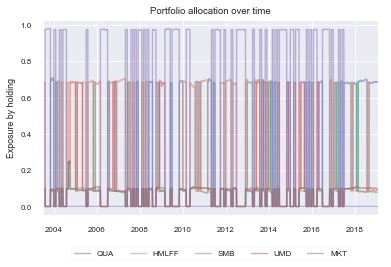

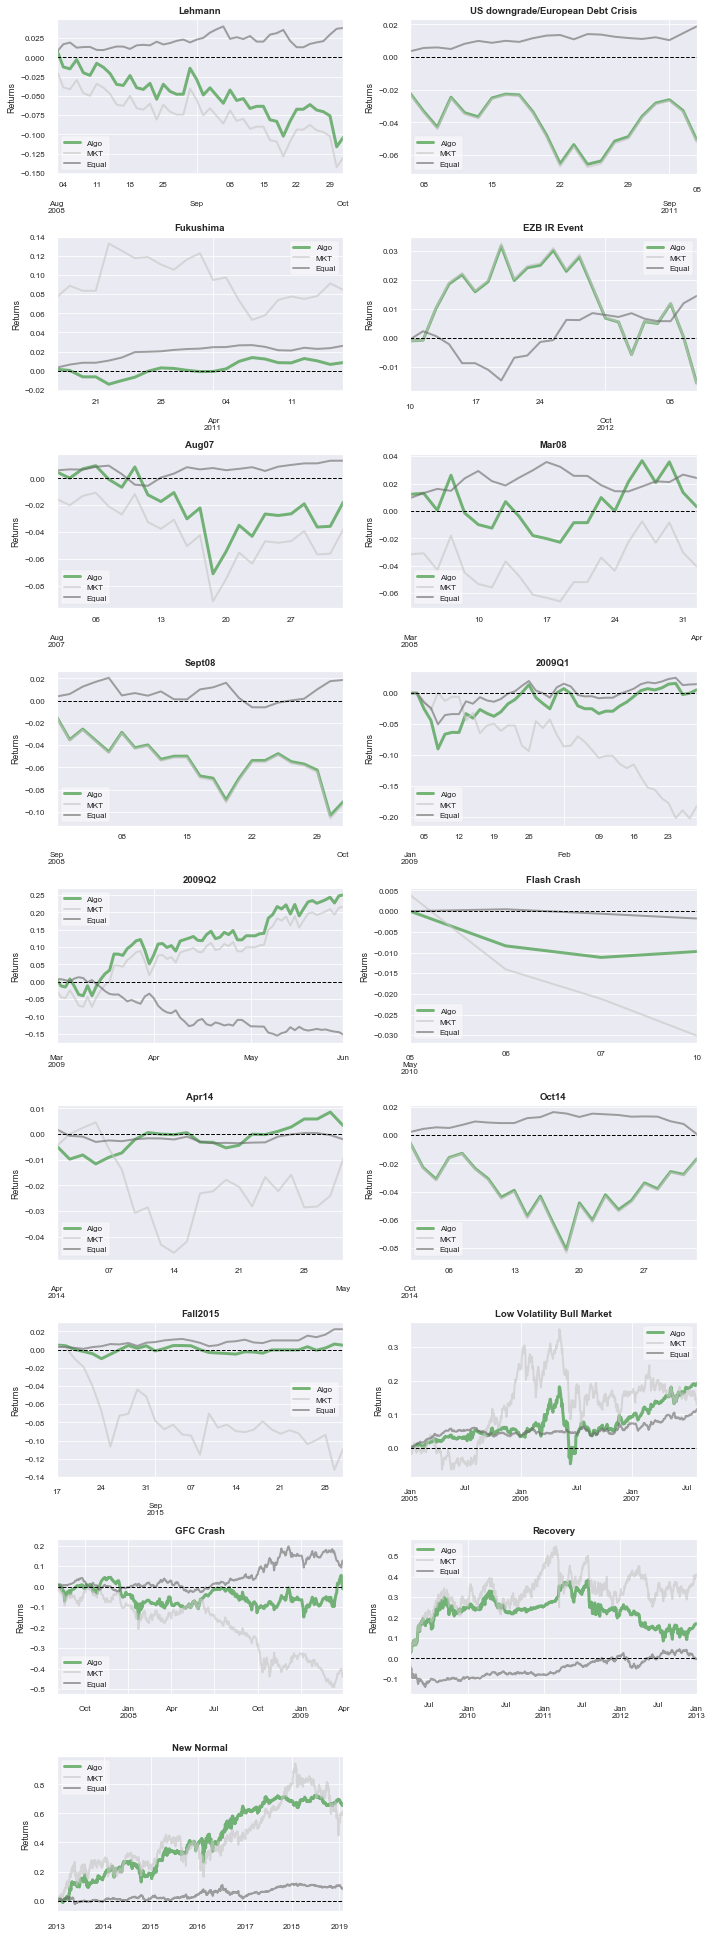

In [5]:
# Backtest with finbox
strat = finbox.backtest.build_weights_rebalance_strategy(
    tickers=['QUA', 'HMLFF', 'SMB', 'UMD', 'MKT'],
    weights=weights,
    datasets=assets,
    lazy_rebalance=True,
    is_debug=False,
    weight_slippage=0.025
)

benchmark1 = preds['returns_mkt']
benchmark1.name = 'MKT'
benchmark1 = benchmark1[benchmark1.index >= weights.index[0]]

benchmark2 = preds['returns_equal']
benchmark2.name = 'Equal'
benchmark2 = benchmark2[benchmark2.index >= weights.index[0]]

# Run Report Builder with matplotlib inside jupyter notebook
rb = finbox.backtest.report.ReportBuilder
rb = rb(strat, [benchmark1, benchmark2])
returns_clean = rb.returns

import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    rb.build_report(chart_type='matplotlib')

## Performance With Transactions

,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,24.82,2006-05-08,2009-01-07,2009-05-11,786
1,24.66,2011-04-19,2012-07-25,2016-09-21,1417
2,11.62,2004-04-07,2006-03-08,2006-05-08,544
3,9.58,2010-04-16,2010-10-08,2011-04-06,254
4,7.42,2003-10-20,2003-10-23,2004-03-22,111


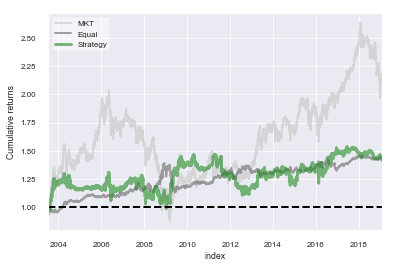

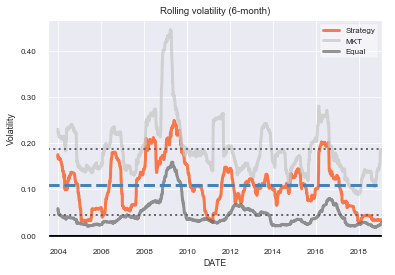

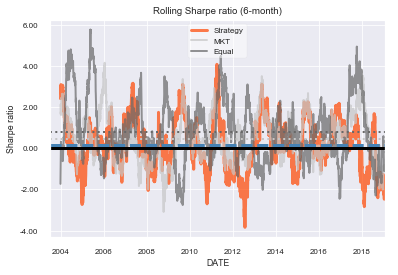

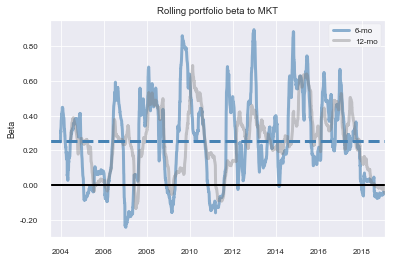

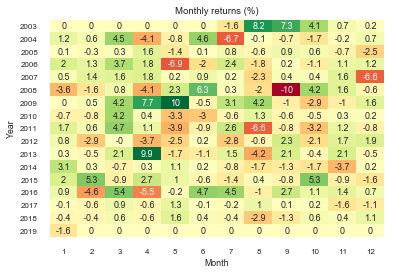

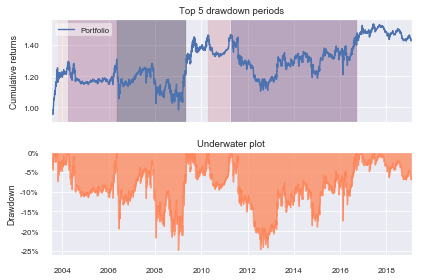

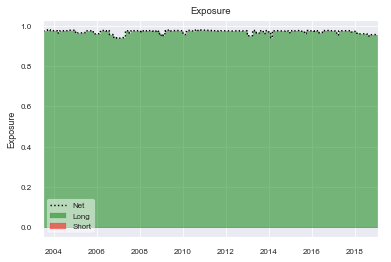

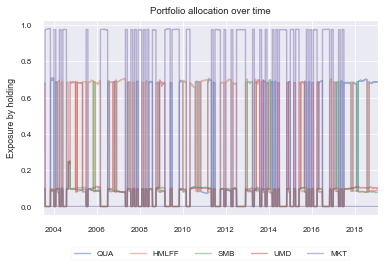

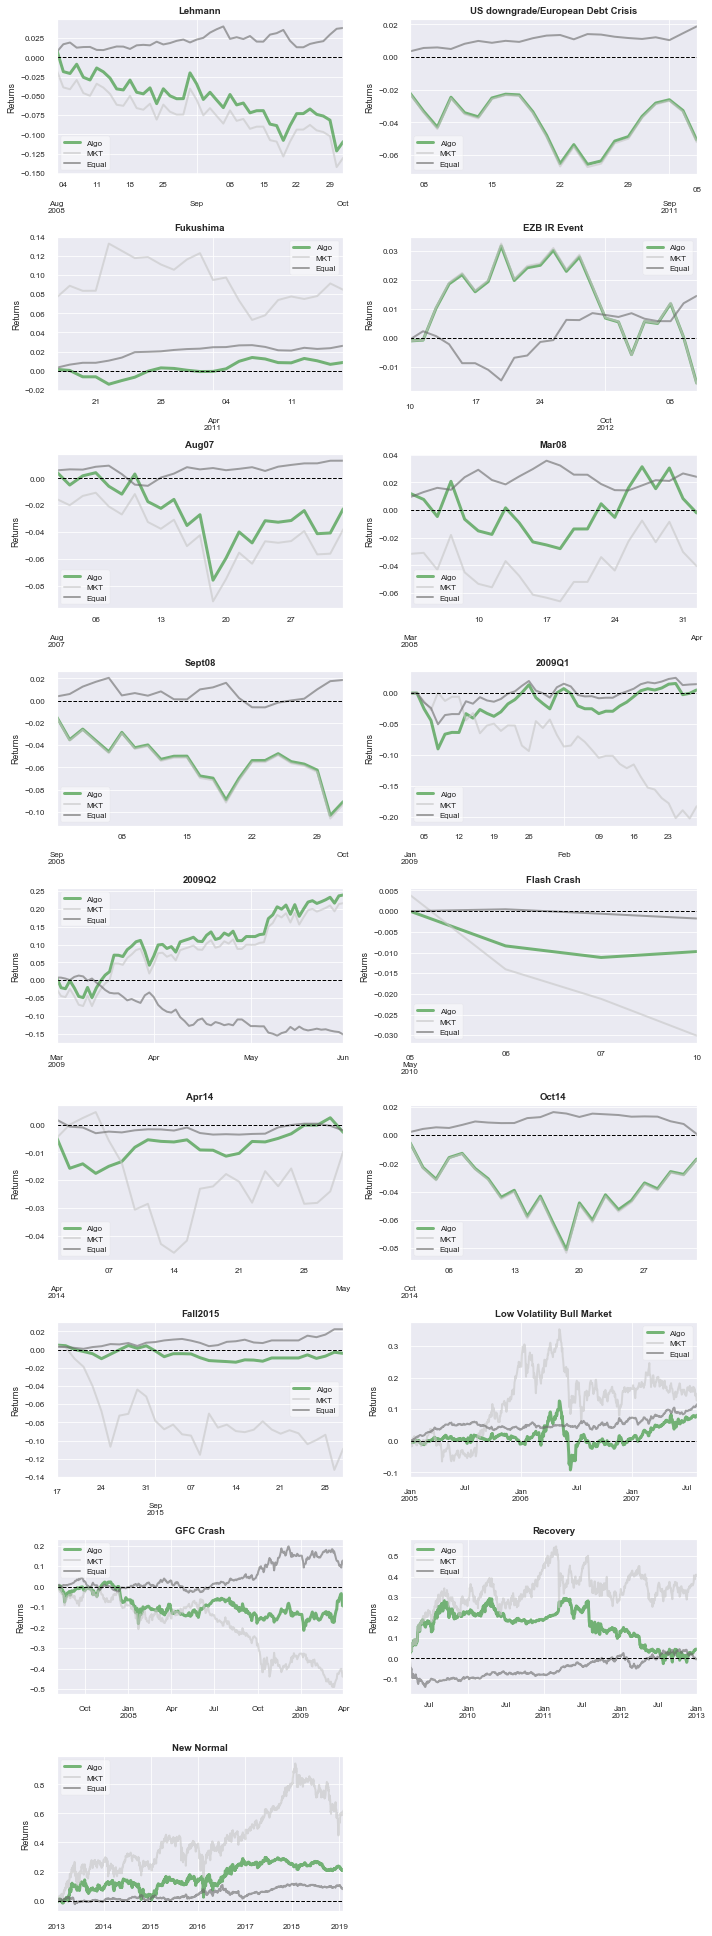

In [6]:
# Backtest with finbox
strat = finbox.backtest.build_weights_rebalance_strategy(
    tickers=['QUA', 'HMLFF', 'SMB', 'UMD', 'MKT'],
    weights=weights,
    datasets=assets,
    lazy_rebalance=True,
    is_debug=False,
    commission_settings=[
        {'commission': 0.01, 'name': 'UMD'},
        {'commission': 0.0035, 'name': 'HMLFF'},
        {'commission': 0.0035, 'name': 'SMB'},
        {'commission': 0.005, 'name': 'QUA'},
        {'commission': 0.001, 'name': 'MKT'}
    ],  # applied 0.1% transaction costs for each trade
    weight_slippage=0.025
)

benchmark1 = preds['returns_mkt']
benchmark1.name = 'MKT'
benchmark1 = benchmark1[benchmark1.index >= weights.index[0]]

benchmark2 = preds['returns_equal']
benchmark2.name = 'Equal'
benchmark2 = benchmark2[benchmark2.index >= weights.index[0]]

# Run Report Builder with matplotlib inside jupyter notebook
rb = finbox.backtest.report.ReportBuilder
rb = rb(strat, [benchmark1, benchmark2])
returns_costs = rb.returns

import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    rb.build_report(chart_type='matplotlib')

## Performance Comparison

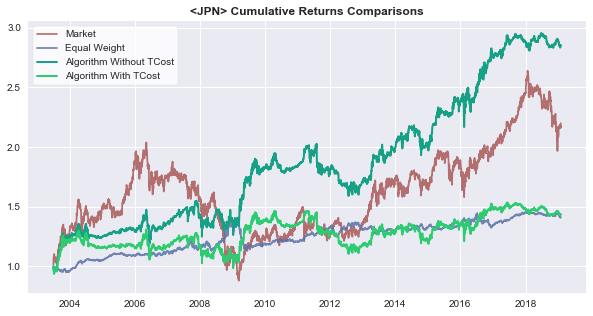

In [50]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.facecolor'] = 'w'

fig, ax = plt.subplots(1,1,figsize=(10,5))

ax.plot((benchmark1 + 1).cumprod(), label='Market', color=utils.COLOR_MAPPER['MKT'], alpha=.85)
ax.plot((benchmark2 + 1).cumprod(), label='Equal Weight', alpha=.85, color=utils.COLOR_MAPPER['equal'])
ax.plot((returns_clean + 1).cumprod(), label='Algorithm Without TCost', color='#16A085', lw=2)
ax.plot((returns_costs + 1).cumprod(), label='Algorithm With TCost', color='#2ECC71', lw=2)
ax.set_title('<%s> Cumulative Returns Comparisons' % country, fontsize=12, fontweight=700)

ax.legend()
fig.savefig(os.path.abspath(os.path.join(os.getcwd(), '..', 'Plots',
                                         'ML_Others', '%s_oos_perf.pdf' % country)), bbox_inches='tight')

## Feature Importances

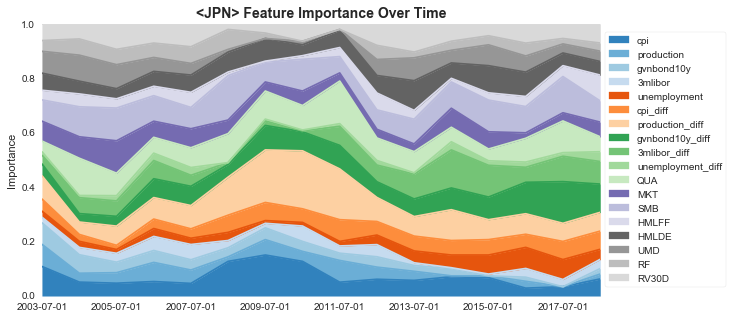

In [52]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))
ax.set_title('<%s> Feature Importance Over Time' % country,
             fontsize=14, fontweight=700)
utils.plot_feature_importance_over_time(preds['models'],
                                        utils.FeatureBuilder().get_features().columns.tolist(),
                                        ax)

fig.savefig(os.path.abspath(os.path.join(os.getcwd(), '..', 'Plots', 'ML_Others', '%s_importance.pdf' % country)), bbox_inches='tight')

## Weights Shifts

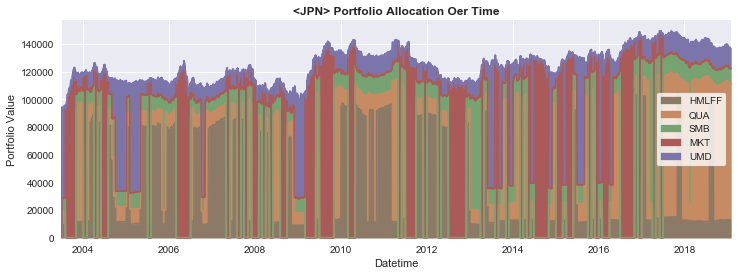

In [51]:
factors = ['HMLFF', 'QUA', 'SMB', 'MKT', 'UMD']
colors=[utils.COLOR_MAPPER[factor] for factor in factors]
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    ax = rb.positions[factors].plot.area(figsize=(12, 4), color=colors)
    ax.set_ylabel('Portfolio Value')
    ax.set_title('<%s> Portfolio Allocation Oer Time' % country,
             fontsize=12, fontweight=700)

plt.savefig(os.path.abspath(os.path.join(os.getcwd(), '..', 'Plots', 'ML_Others', '%s_weights.pdf' % country)), bbox_inches='tight')

## Confusion Matrix

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          ax=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [11]:
aqr = utils.load_aqr_data(country).dropna()
portfolios = utils.build_portfolio(aqr, main_weights=[0.7],
                                   prefix_names=['main'],
                                   include_mkt=True)
rf = aqr['RF'].dropna()
mkt = aqr['MKT'].dropna()
po = utils.PortfolioOptimizer(portfolios=portfolios,
                              riskfree=rf,
                              market=mkt,
                              country=country)

po.get_stats_table()
po.get_best_indicators()

y_true, true_labels = po.get_labels()

# y_pred = preds['preds'].dropna().astype(int).values.flatten()
# y_true = y_true.loc[preds['preds'].dropna().index].astype(int).values.flatten()

y_pred = preds['preds'].dropna()
y_true = y_true.loc[y_pred.index]
for i, label in enumerate(true_labels):
    y_pred = y_pred.replace(i, label)
    y_true = y_true.replace(i, label)

Normalized confusion matrix
[[0.43181818 0.         0.27272727 0.06818182 0.02272727 0.20454545]
 [0.1        0.         0.3        0.4        0.         0.2       ]
 [0.425      0.025      0.175      0.325      0.         0.05      ]
 [0.325      0.         0.175      0.3        0.05       0.15      ]
 [0.42857143 0.         0.23809524 0.23809524 0.04761905 0.04761905]
 [0.19354839 0.         0.4516129  0.19354839 0.09677419 0.06451613]]


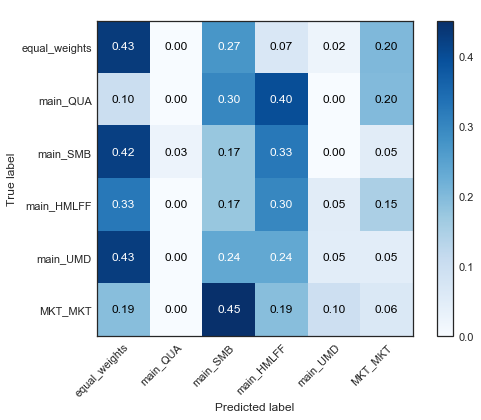

In [12]:
import matplotlib as mpl
mpl.style.use('seaborn-white')

fig, ax = plt.subplots(1,1,figsize=(8,6))
plot_confusion_matrix(y_true, y_pred, classes=true_labels, normalize=True, title=' ', ax=ax)
fig.savefig(os.path.abspath(os.path.join(os.getcwd(), '..', 'Plots', 'ML_Others', '%s_cm.pdf' % country)), bbox_inches='tight')

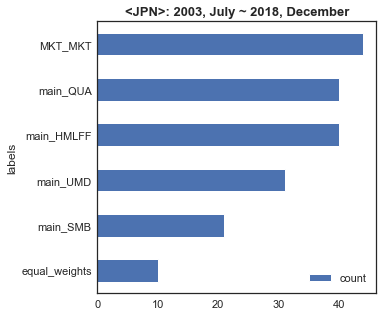

In [49]:
y_true['count'] = 1
fig, ax = plt.subplots(1,1,figsize=(5,5))
y_true.groupby('labels').sum().sort_values(by='count').plot.barh(ax=ax)
ax.set_title('<%s>: %s ~ %s' % (country, y_true.index[0].strftime('%Y, %B'),
                                y_true.index[-1].strftime('%Y, %B')), fontweight=700, fontsize=13)
fig.savefig(os.path.abspath(os.path.join(os.getcwd(), '..', 'Plots', 'ML_Others', '%s_oos_dist.pdf' % country)), bbox_inches='tight')

In [54]:
print(preds['labels'])
preds['preds'][preds['preds'].index >= '2016-07-01']

['equal_weights', 'main_QUA', 'main_SMB', 'main_HMLFF', 'main_UMD', 'MKT_MKT']


,labels
DATE,
2016-07-01,5.0
2016-08-01,5.0
2016-09-01,5.0
2016-10-01,5.0
2016-11-01,3.0
2016-12-01,5.0
2017-01-01,3.0
2017-02-01,1.0
2017-03-01,2.0


In [55]:
y_true[y_true.index >= '2016-07-01']

,labels,count
DATE,,
2016-07-01,MKT_MKT,1
2016-08-01,main_HMLFF,1
2016-09-01,main_SMB,1
2016-10-01,main_HMLFF,1
2016-11-01,main_HMLFF,1
2016-12-01,main_HMLFF,1
2017-01-01,main_UMD,1
2017-02-01,main_SMB,1
2017-03-01,main_QUA,1
